In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import json
import h5py
from scipy.sparse import load_npz

# Import user-defined libraries:
sys.path.append(os.path.abspath('/Users/martina/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Git/rom-cylinder_DEIM-POD/offline-online stages/fit White/0. full order'))
from FreeFEM import FFmatrix_fread, FFvector_fread

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_4476/1986896891.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_4476/1986896891.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


In [2]:
# Load coordinates:
coordinates_Px = FFvector_fread('../../0. full order/mesh_utilities/vv_cc_Px.btxt')
coordinates_Pq = FFvector_fread('../../0. full order/mesh_utilities/vv_cc_Pq.btxt')

# Identify degrees of freedom of the Px and Pq spaces:
sFO_Px = coordinates_Px.shape[0]
sFO_Pq = coordinates_Pq.shape[0]

# Define vector of all Px indeces:
mask_all = np.arange(sFO_Px, dtype=int)

# Identify indeces of the top, bottom and middle boundaries in Px:
mask_inf_bc = mask_all[np.isclose([coordinates_Px[ii, 2] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_sup_bc = mask_all[np.isclose([coordinates_Px[ii, 2] for ii in range(sFO_Px)], np.ones((sFO_Px)))]
mask_mid_bc = mask_all[np.isclose([np.linalg.norm(coordinates_Px[ii, :2]) for ii in range(sFO_Px)], np.ones((sFO_Px)))]

# Identify indeces of the Dirichlet b.c. for the temperature and concentration field:
mask_bc_T = np.fromiter(set(mask_sup_bc), int)
mask_bc_C = np.fromiter(set(mask_sup_bc) | set(mask_mid_bc) | set(mask_inf_bc), int)

# Identify indeces of the interior for the temperature and concentration field:
mask_in_T = [ii for ii in mask_all if ii not in mask_bc_T]
mask_in_C = [ii for ii in mask_all if ii not in mask_bc_C]

In [6]:
# Apri il file in modalità lettura
with h5py.File('../matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    MM_RB = hf['MM_RB'][:]
    FF_RB = hf['FF_RB'][:]
    KK_RB = hf['KK_RB'][:]
    AA_RB = hf['AA_RB'][:]
    ZZ_CO = hf['ZZ_CO'][:]
    II_CO = hf['II_CO'][:]
    basis = hf['basis'][:]

xz_y = load_npz('../../0. full order/mesh_utilities/xz_y_0.npz')
xy_z = load_npz('../../0. full order/mesh_utilities/xz_y_0.npz')

In [7]:
n_dofs = coordinates_Px.shape[0]
n_cols = basis.shape[1]
basis_extended = np.zeros((n_dofs, n_cols))
basis_extended[mask_in_C, :] = basis

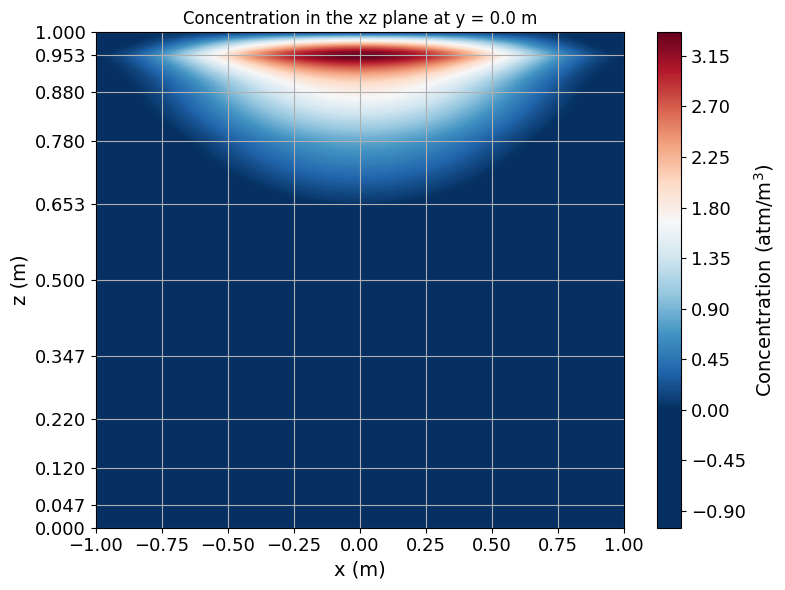

In [11]:
PP = 99  
x_coords_at_y = np.empty(((PP+1)*(PP+1)))
z_coords_at_y = np.empty(((PP+1)*(PP+1)))
for ii in range(PP+1):
    for jj in range(PP+1):
        index = (PP+1)*ii + jj
        x_coords_at_y[index] = 2 * (ii / PP) - 1  
        z_coords_at_y[index] = jj / PP  

# Converti in array NumPy
x_coords_at_y = np.array(x_coords_at_y)
z_coords_at_y = np.array(z_coords_at_y)

total_layers = list(set(coordinates_Px[:,2]))
effective_layers = sorted(list(set(coordinates_Px[:,2])))[::2]

concentration_at_y = xz_y @ basis_extended[:, 1]
plt.figure(figsize=(8, 6))
contour = plt.tricontourf(x_coords_at_y, z_coords_at_y, concentration_at_y, 400, cmap='RdBu_r', vmin=0)
cbar = plt.colorbar(contour)       # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('Concentration (atm/m$^3$)', fontsize=14)

plt.title(f'Concentration in the xz plane at y = {0.00} m')
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlim([-1, 1])
plt.yticks(effective_layers)
plt.xlabel('x (m)',fontsize=14)
plt.ylabel('z (m)',fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('FOM_xz_brutal.pdf', bbox_inches='tight') 


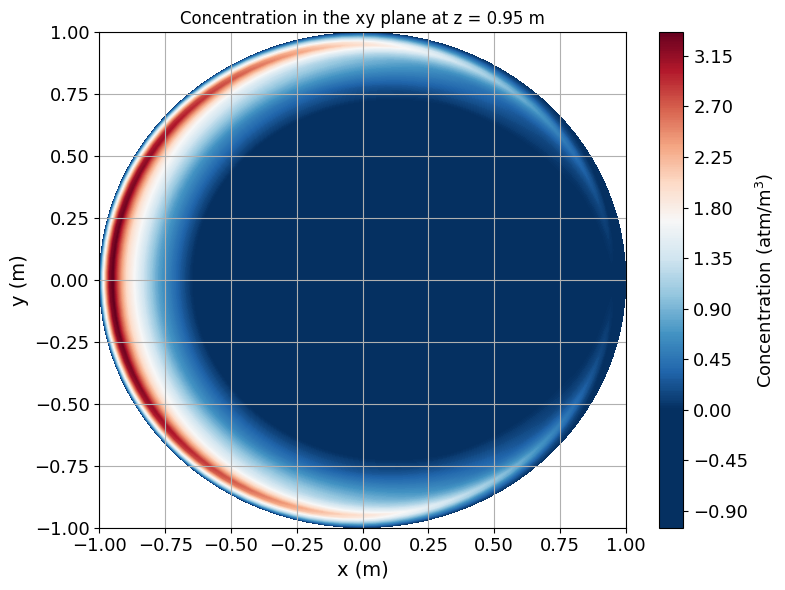

In [14]:
PP=99
rmax = 1.0  # Raggio massimo
thetamax = 2 * np.pi  # Angolo massimo (2pi per un cerchio completo)

# Coordinate cartesiane x e y
x_coords_at_z = np.empty(((PP + 1) * (PP + 1)))
y_coords_at_z = np.empty(((PP + 1) * (PP + 1)))

# Genera le coordinate cartesiane
for ii in range(PP + 1):
    for jj in range(PP + 1):
        index = (PP + 1) * ii + jj
        r = (jj / PP) * rmax  # Distanza radiale
        theta = (ii / PP) * thetamax  # Angolo
        # Calcola le coordinate cartesiane (x, y)
        x_coords_at_z[index] = r * np.cos(theta)
        y_coords_at_z[index] = r * np.sin(theta)

# Converti in array NumPy
x_coords_at_z= np.array(x_coords_at_z)
y_coords_at_z = np.array(y_coords_at_z)

concentration_at_z = xy_z @ basis_extended[:, 1]

# Crea il grafico 2D della concentrazione nel piano xy a z = z_target
plt.figure(figsize=(8, 6))
contour = plt.tricontourf(x_coords_at_z, y_coords_at_z, concentration_at_z, 400, cmap='RdBu_r', vmin = 0)
cbar = plt.colorbar(contour)  # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('Concentration (atm/m$^3$)', fontsize=13)

plt.title(f'Concentration in the xy plane at z = {0.95} m')
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlabel('x (m)',fontsize=14)
plt.ylabel('y (m)',fontsize=14)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.grid(True)
plt.tight_layout()
plt.savefig('FOM_xy.pdf', bbox_inches='tight') 

## **Old**

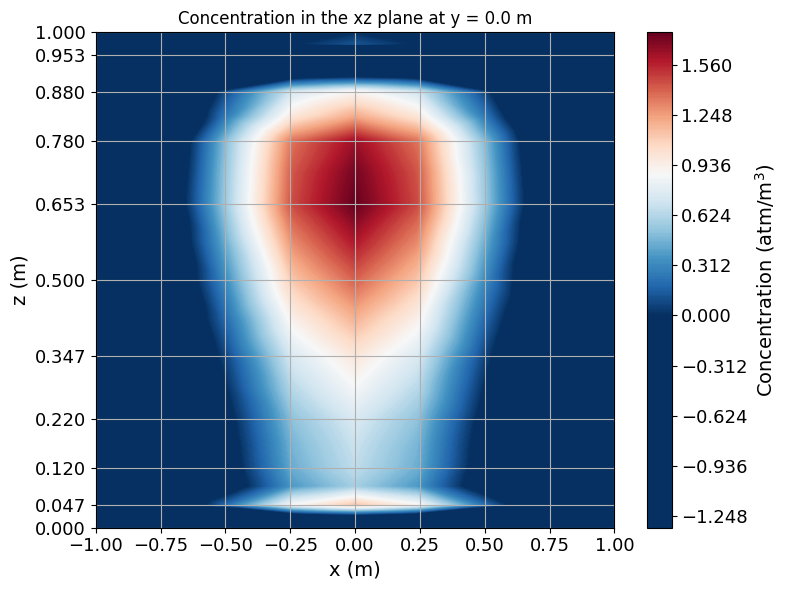

In [76]:
y_target = 0.0  
tolerance = 1E-6
mask_y = np.abs(coordinates_Px[:,1] - y_target) < tolerance
x_coords_at_y = coordinates_Px[mask_y, 0]  
z_coords_at_y = coordinates_Px[mask_y, 2] 

total_layers = list(set(coordinates_Px[:,2]))
effective_layers = sorted(list(set(coordinates_Px[:,2])))[::2]

concentration_at_y = basis_extended[mask_y, 2]  # Concentrazione all'ultimo istante temporale
# Crea il grafico 2D della concentrazione nel piano xz a y = y_target
plt.figure(figsize=(8, 6))
contour = plt.tricontourf(x_coords_at_y, z_coords_at_y, concentration_at_y, 400, cmap='RdBu_r', vmin=0)
cbar = plt.colorbar(contour)       # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('Concentration (atm/m$^3$)', fontsize=14)

plt.title(f'Concentration in the xz plane at y = {y_target} m')
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlim([-1, 1])
plt.yticks(effective_layers)
plt.xlabel('x (m)',fontsize=14)
plt.ylabel('z (m)',fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('FOM_xz.pdf', bbox_inches='tight') 

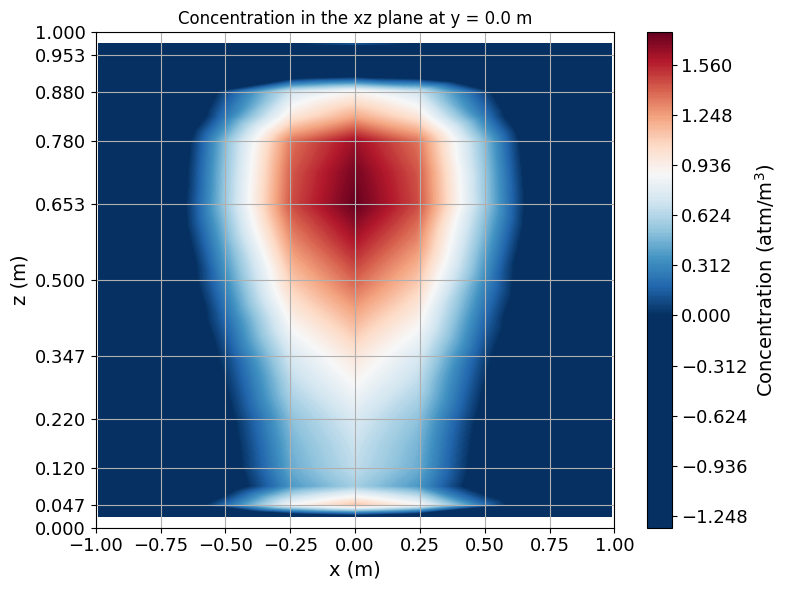

In [ ]:
#Grafico in cui considero mask_in_C
y_target = 0.0  
tolerance = 1E-6
coordinates_Px_in_C = coordinates_Px[mask_in_C]
mask_y = np.abs(coordinates_Px_in_C[:,1] - y_target) < tolerance
x_coords_at_y = coordinates_Px_in_C [mask_y, 0]  
z_coords_at_y = coordinates_Px_in_C [mask_y, 2] 

total_layers = list(set(coordinates_Px[:,2]))
effective_layers = sorted(list(set(coordinates_Px[:,2])))[::2]


concentration_at_y = basis[mask_y, 2]  # Concentrazione all'ultimo istante temporale
# Crea il grafico 2D della concentrazione nel piano xz a y = y_target
plt.figure(figsize=(8, 6))
contour = plt.tricontourf(x_coords_at_y, z_coords_at_y, concentration_at_y, 400, cmap='RdBu_r', vmin=0)
cbar = plt.colorbar(contour)       # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('Concentration (atm/m$^3$)', fontsize=14)

plt.title(f'Concentration in the xz plane at y = {y_target} m')
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlim([-1, 1])
plt.yticks(effective_layers)
plt.xlabel('x (m)',fontsize=14)
plt.ylabel('z (m)',fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('FOM_xz.pdf', bbox_inches='tight') 
